In [1]:
%load_ext autoreload
%autoreload 2

### Preprocessing scmultiome data from Curtis Boswell.
Analysis of single nuclear expression data only.

Modeling vertebrate organogenesis in zebrafish across 3 timepoints (12hr, 18hr, 24hr).

Matched ATAC data is available for each cell.

Aim: map transcription factor activation controlling lineage differentiation during vertebrate orgnogenesis.

In [2]:
import os, scprep, warnings, scanpy as sc 
warnings.filterwarnings('ignore')

from degex.preprocessing import (
    prepare_h5ad_file,
    filter_pipeline,
    normalization_pipeline,
    embedding_pipeline,
)

In [3]:
from degex.types import OBS_BATCH

In [4]:
DATA_DIR = os.path.abspath('../data')
def make_filename(hr:str, data_dir:str=DATA_DIR):
    rootname = 'scmultiome_121824_seq2'
    return os.path.join(
        data_dir, 
        f'{rootname}_{hr}_cr200_run1',
        'filtered_feature_bc_matrix.h5'
    )

f1 = make_filename('12h')
f2 = make_filename('18h')
f3 = make_filename('24h')

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 3.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.2%
Elapsed time: 1.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 6.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.8%
Elapsed time: 3.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 6.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.4%
Elapsed time: 1.2 seconds


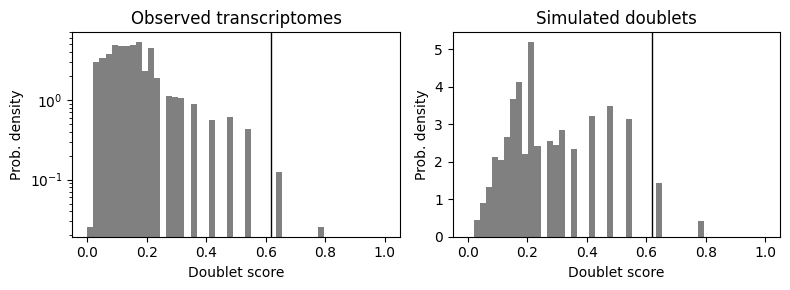

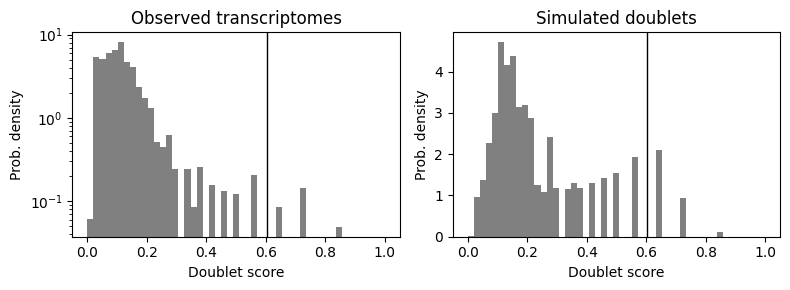

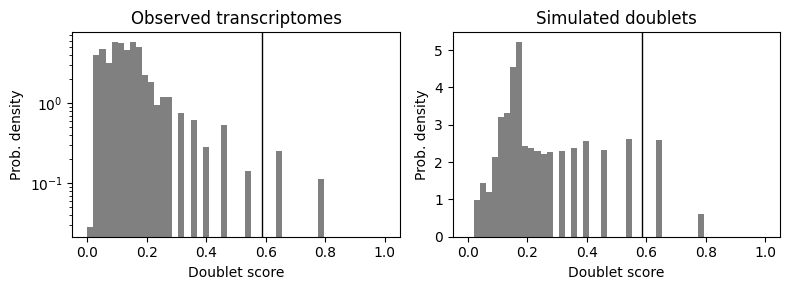

In [5]:
sdata1 = prepare_h5ad_file(f1, plot=True)
sdata2 = prepare_h5ad_file(f2, plot=True)
sdata3 = prepare_h5ad_file(f3, plot=True)

In [6]:
from degex.adata import (
    combine_timepoints, add_gene_annotations,
    calc_qc_stats
) 

In [7]:
adata = combine_timepoints(
    sdata1, sdata2, sdata3, 
    idx_to_time={'0': '12hr', '1': '18hr', '2': '24hr'},
    print_counts=True
)

18hr    4056
12hr    1944
24hr    1748
Name: batch, dtype: int64


In [8]:
adata = add_gene_annotations(
    adata, 
    os.path.join(DATA_DIR, 'genes', 'Gene_annotation.csv'),    
)

In [9]:
adata = calc_qc_stats(adata)

In [10]:
from degex.types import CutoffSpecification
adata = filter_pipeline(
    adata, 
    cutoff_specs=[
        CutoffSpecification('total_counts', 500, 10000),
        CutoffSpecification('pct_counts_mito', None, 15),
        # CutoffSpecification('pct_counts_ribo', None, 15),
        # CutoffSpecification('doublet_scores', None, 0.4),
    ],
    min_cells=5
)

In [11]:
adata.obs.batch.value_counts()

18hr    3544
12hr    1708
24hr    1542
Name: batch, dtype: int64

<Axes: ylabel='Number of cells'>

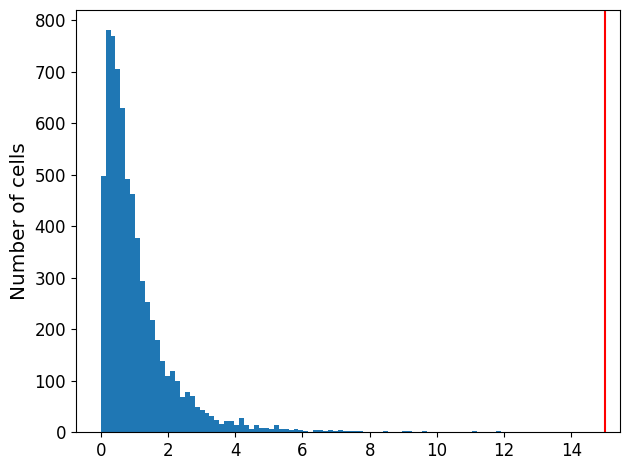

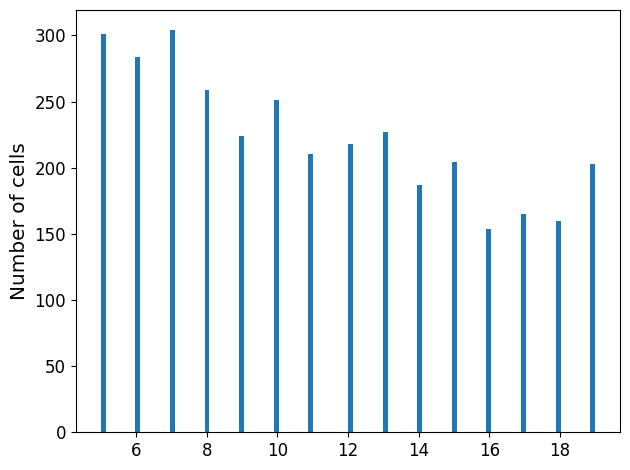

In [12]:
scprep.plot.histogram(adata.obs["pct_counts_mito"], cutoff=15)
scprep.plot.histogram(adata[:,adata.var.n_cells_by_counts < 20].var["n_cells_by_counts"])

In [13]:
from degex.types import VAR_HUMAN_GENE_SYMBOL
cell_cycle_genes = [
    x.strip() 
    for x in open(f'{DATA_DIR}/genes/regev_lab_cell_cycle_genes.txt')
]
s_genes = cell_cycle_genes[:43]
s_genes = adata.var.index[adata.var[VAR_HUMAN_GENE_SYMBOL].isin(s_genes)]
g2m_genes = cell_cycle_genes[43:]
g2m_genes = adata.var.index[adata.var[VAR_HUMAN_GENE_SYMBOL].isin(g2m_genes)]


In [14]:
adata = normalization_pipeline(adata, s_genes, g2m_genes)

In [15]:
adata, g, g_hvg = embedding_pipeline(adata)

g is None. Will attempt to calculate with PCA stored in adata.obsmX_pca.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 6794 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.56 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.39 seconds.
  Calculated landmark operator in 5.45 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.00 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.14 seconds.
Calculated PHATE in 11.62 seconds.
Unique HVGs after 12hr 2177
Unique HVGs after 18hr 2991
Unique HVGs after 24hr 3322
g is None. Will attempt to calculate with PCA stored in adata.obsmX_pca_hvg.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 6794 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion 

In [16]:
VOIs=['total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'pct_counts_in_top_50_genes', 'n_genes_by_counts', 'phase', 'batch', 'doublet_scores']

In [28]:
'phase' in adata.obs.columns

False

In [30]:
adata.obs.join(adata.obs.phase)

doublet_scores  predicted_doublets batch timepoint  \
AAACATGCATTAAGCT-1_0        0.243697               False  12hr        12   
AAACCAACAGCTTAAT-1_0        0.052632               False  12hr        12   
AAACCGCGTGTTGCAA-1_0        0.110588               False  12hr        12   
AAACGTACAAGGTATA-1_0        0.152941               False  12hr        12   
AAACGTACAATCTCTC-1_0        0.073529               False  12hr        12   
...                              ...                 ...   ...       ...   
TTTGGCTGTTAGGCGT-1_2        0.458647               False  24hr        24   
TTTGGTAAGCGCAATT-1_2        0.072519               False  24hr        24   
TTTGTCCCAAACTGTT-1_2        0.168317               False  24hr        24   
TTTGTGGCAAGCCACT-1_2        0.092105               False  24hr        24   
TTTGTTGGTTTGCTGT-1_2        0.181818               False  24hr        24   

                      n_genes_by_counts  log1p_n_genes_by_counts  \
AAACATGCATTAAGCT-1_0                676                 6.517671   
AAACCAACAGCTTAAT-1_0               1601                 7.379008   
AAACCGCGTGTTGCAA-1_0               1715                 7.447751   
AAACGTACAAGGTATA-1_0               1370                 7.223296   
AAACGTACAATCTCTC-1_0               2098                 7.649216   
...                                 ...                      ...   
TTTGGCTGTTAGGCGT-1_2               2077                 7.639161   
TTTGGTAAGCGCAATT-1_2                589                 6.380123   
TTTGTCCCAAACTGTT-1_2               2909                 7.975908   
TTTGTGGCAAGCCACT-1_2               1099                 7.003065   
TTTGTTGGTTTGCTGT-1_2               1379                 7.229839   

                      total_counts  log1p_total_counts  \
AAACATGCATTAAGCT-1_0         892.0            6.794587   
AAACCAACAGCTTAAT-1_0        2700.0            7.901377   
AAACCGCGTGTTGCAA-1_0        2678.0            7.893199   
AAACGTACAAGGTATA-1_0        1981.0            7.591862   
AAACGTACAATCTCTC-1_0        3867.0            8.260493   
...                            ...                 ...   
TTTGGCTGTTAGGCGT-1_2        5192.0            8.555067   
TTTGGTAAGCGCAATT-1_2         778.0            6.658011   
TTTGTCCCAAACTGTT-1_2        5802.0            8.666130   
TTTGTGGCAAGCCACT-1_2        1631.0            7.397562   
TTTGTTGGTTTGCTGT-1_2        2181.0            7.687997   

                      pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACATGCATTAAGCT-1_0                   21.412556                    32.623318   
AAACCAACAGCTTAAT-1_0                   17.518519                    25.555556   
AAACCGCGTGTTGCAA-1_0                   13.480209                    21.023152   
AAACGTACAAGGTATA-1_0                   13.023725                    20.747097   
AAACGTACAATCTCTC-1_0                   16.524438                    23.791052   
...                                          ...                          ...   
TTTGGCTGTTAGGCGT-1_2                   24.383667                    35.092450   
TTTGGTAAGCGCAATT-1_2                   22.107969                    34.961440   
TTTGTCCCAAACTGTT-1_2                   14.788004                    21.009997   
TTTGTGGCAAGCCACT-1_2                   17.657879                    26.854690   
TTTGTTGGTTTGCTGT-1_2                   18.340211                    26.364053   

                      pct_counts_in_top_200_genes  \
AAACATGCATTAAGCT-1_0                    46.636771   
AAACCAACAGCTTAAT-1_0                    37.555556   
AAACCGCGTGTTGCAA-1_0                    32.225541   
AAACGTACAAGGTATA-1_0                    32.458354   
AAACGTACAATCTCTC-1_0                    33.798810   
...                                           ...   
TTTGGCTGTTAGGCGT-1_2                    47.669492   
TTTGGTAAGCGCAATT-1_2                    50.000000   
TTTGTCCCAAACTGTT-1_2                    30.041365   
TTTGTGGCAAGCCACT-1_2                    39.362354   
TTTGTTGGTTTGCTGT-1_2                   

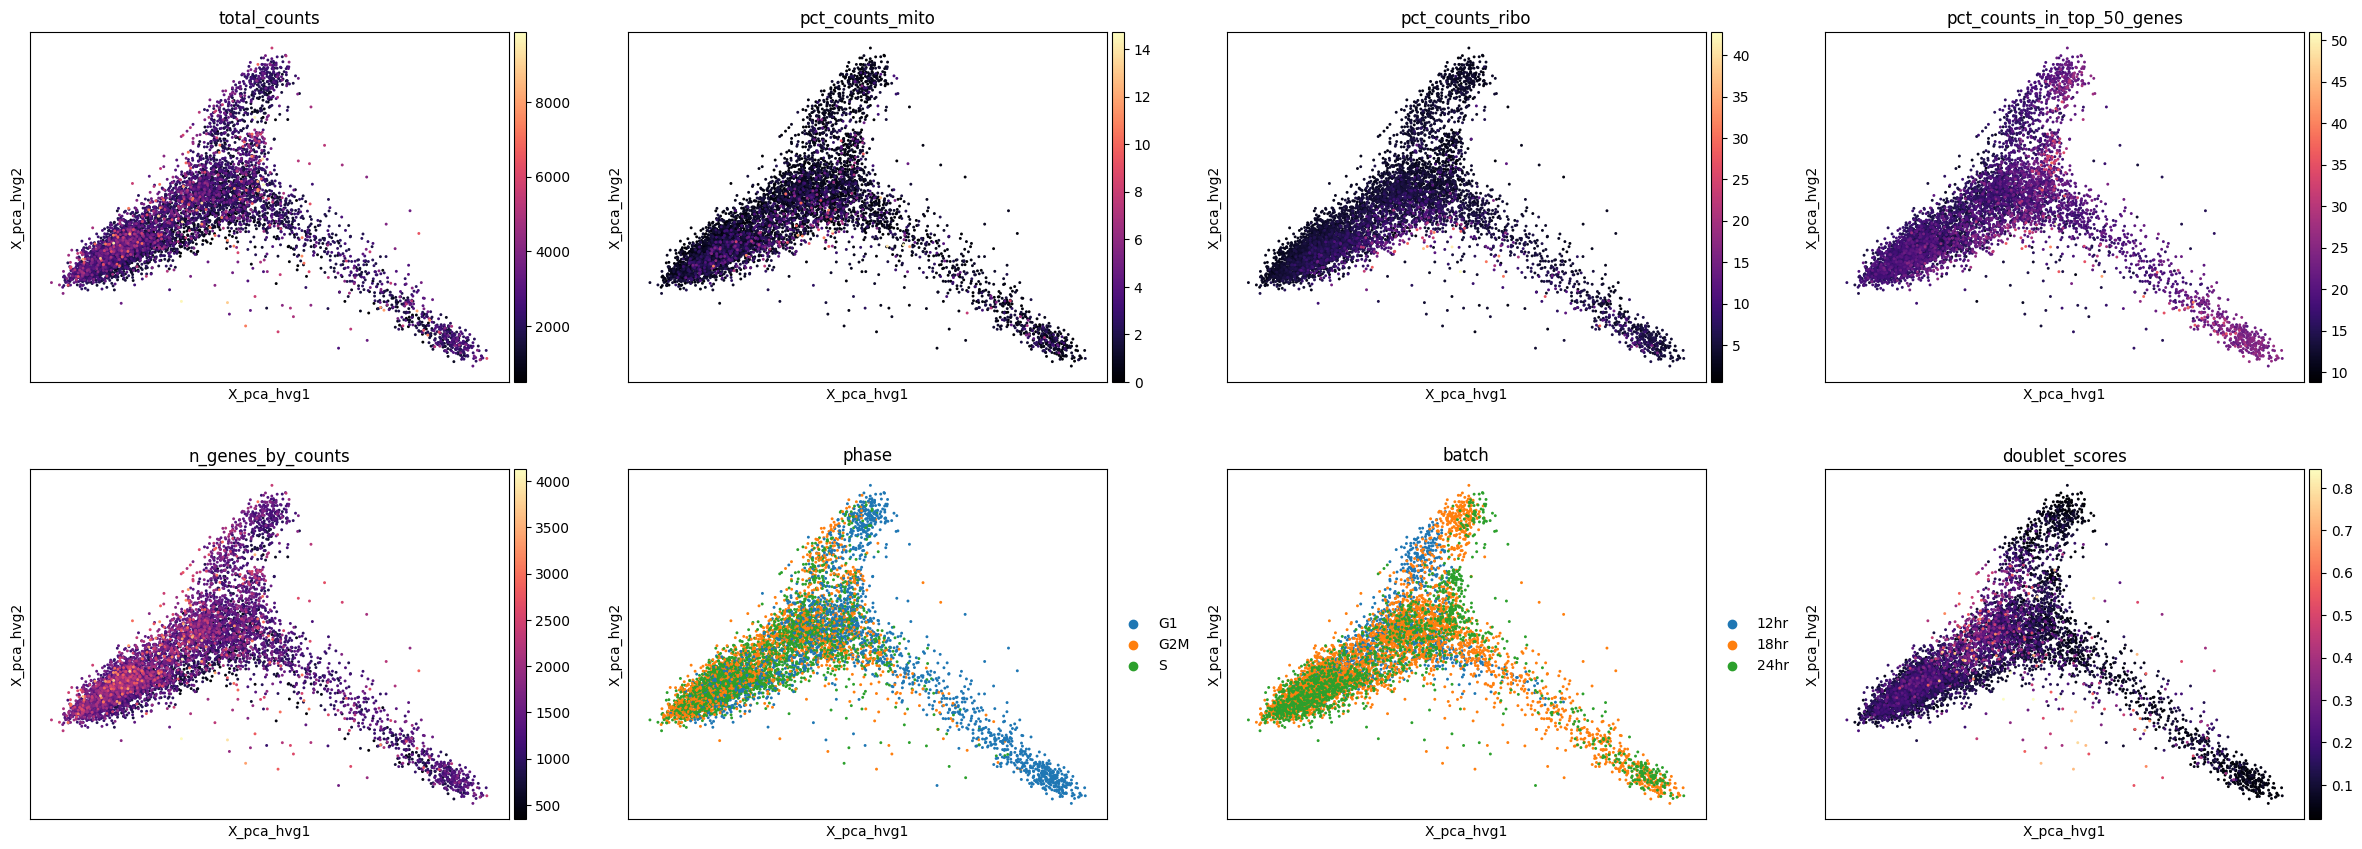

In [17]:
sc.pl.embedding(adata, basis='X_pca_hvg', color=VOIs, color_map='magma')

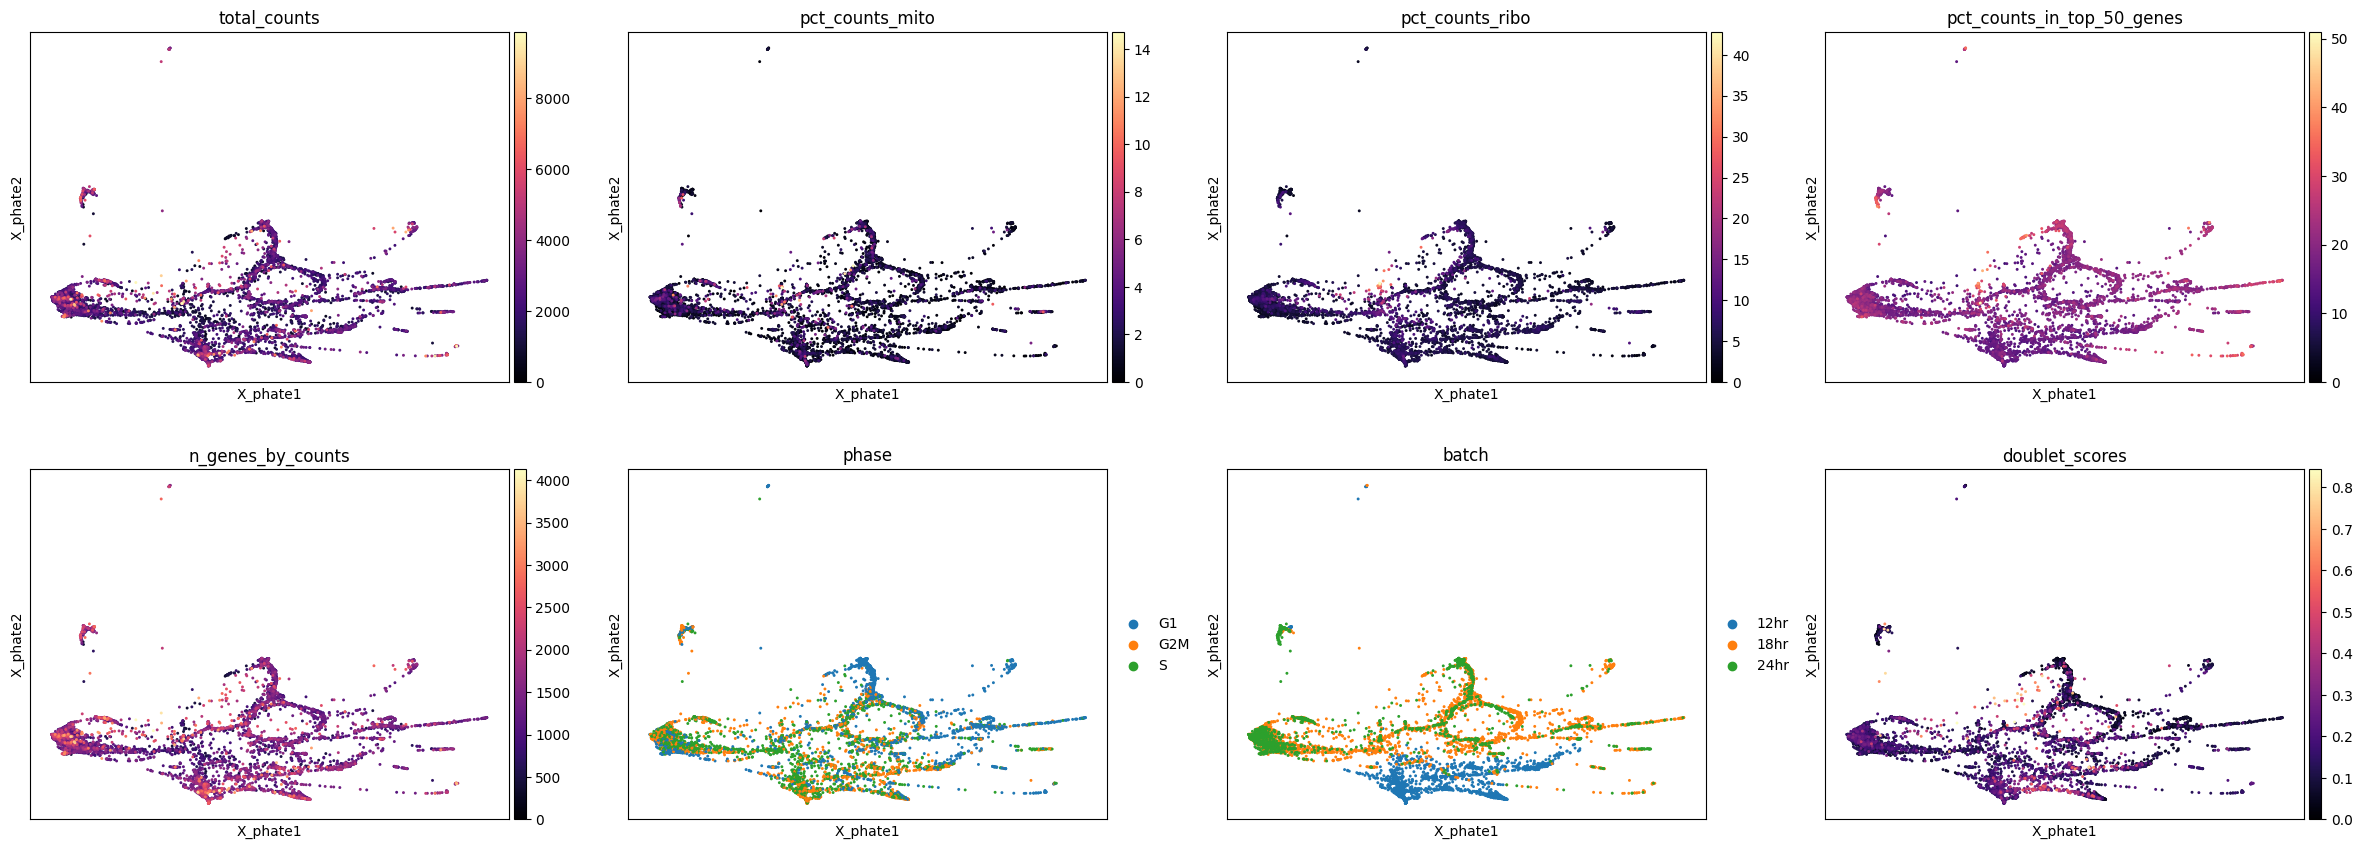

In [18]:
sc.pl.embedding(adata, basis='X_phate', sort_order=True, vmin=0, color=VOIs, use_raw = False, color_map='magma')

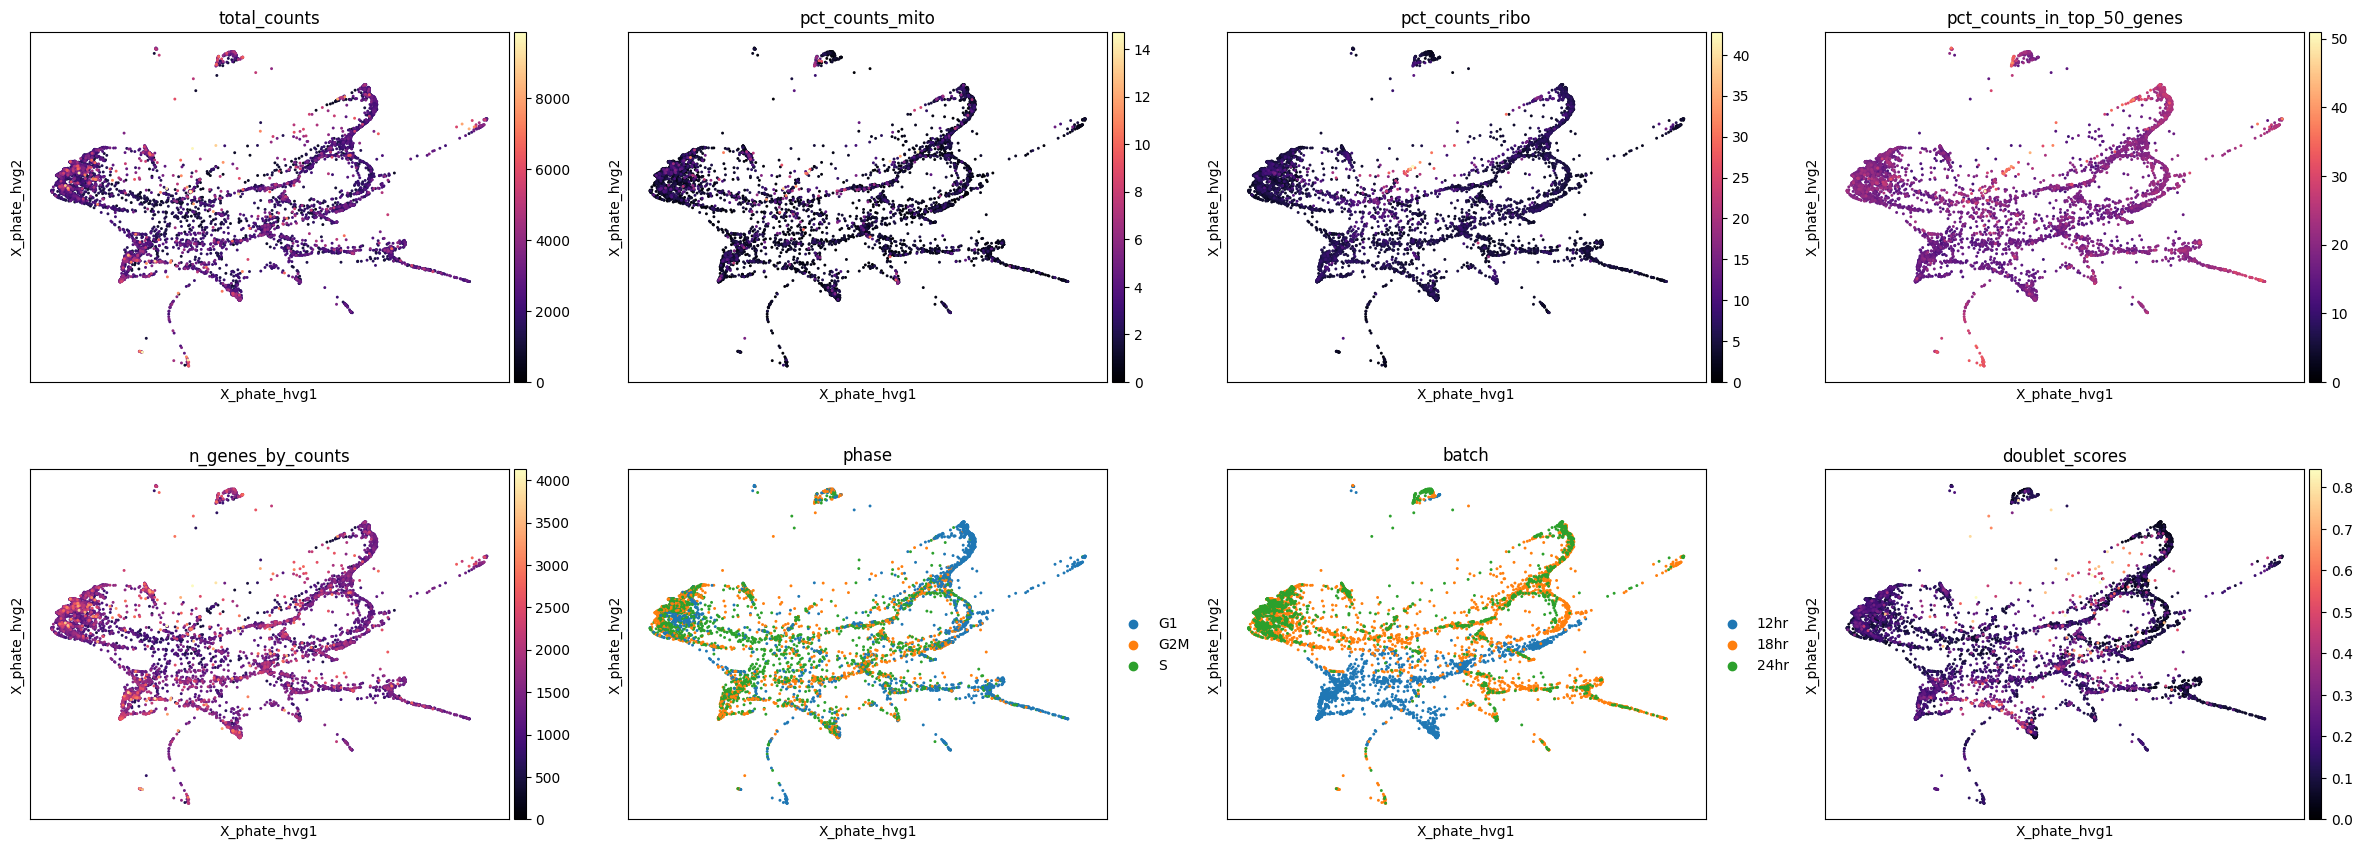

In [19]:
sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=VOIs, use_raw = False, color_map='magma')


In [25]:
from degex.adata import (
    add_tf_annotations_from_csv,
    add_human_tfs_from_csv,
    add_mouse_tfs_from_csv
)
import pandas as pd

In [26]:
tf_annotation = pd.read_csv(f'{DATA_DIR}/genes/Danio_rerio_ensembl_tfs.csv', index_col=None, header=0).astype(str)
adata.var['TFs'] = adata.var.Ensembl.isin(tf_annotation.gene_stable_id)
adata.var['TFs'].value_counts()

False    20507
True      1260
Name: TFs, dtype: int64

In [27]:
adata = add_human_tfs_from_csv(
    adata, 
    os.path.join(DATA_DIR, 'genes', 'Homo_sapien_ensembl_tfs_v_1.01.csv')
)

In [28]:
adata = add_mouse_tfs_from_csv(
    adata, 
    os.path.join(DATA_DIR, 'genes', 'Mus_musculus_ensembl_tfs.csv')
)

In [29]:
# TFs in any species
adata.var['AnySpecies_TFs'] = adata.var['MouseTFs'] | adata.var['HumanTFs'] | adata.var['TFs']
adata.var['AnySpecies_TFs'].value_counts()


False    19973
True      1794
Name: AnySpecies_TFs, dtype: int64

In [30]:
adata

AnnData object with n_obs × n_vars = 6794 × 21767
    obs: 'doublet_scores', 'predicted_doublets', 'batch', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'log10_total_counts', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'Ensembl', 'EntrezID', 'ZFinID', 'ZFinSymbol', 'GeneSymbol', 'Description', 'Biotype', 'HumanEnsemblID', 'HumanGeneSymbol', 'HumanEntrezID', 'MouseEnsemblID', 'MouseGeneSymbol', 'MouseEntrezID', 'ZFinTissueTime', 'ZFinDescription', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable_12hr', 'highly_variable

In [42]:
gene_annotation = pd.read_csv(f'{DATA_DIR}/genes/Gene_annotation.csv', index_col=None, header=0).astype(str)
gene_annotation.index = list(gene_annotation.Ensembl)

In [43]:
# Make a list of marker genes (12hr from Shier lab data)
marker_annotation = pd.read_csv(f'{DATA_DIR}/genes/farrell_boswell_larval_zebrafish_marker_genes_ensembl104.csv', index_col=None, header=0).astype(str)
marker_annotation = pd.merge(marker_annotation, gene_annotation, left_on="gene_stable_id", right_on="Ensembl", how='inner')
marker_annotation['tissue'] = marker_annotation['tissue'].str.replace(' / ','-')
marker_annotation['tissue'] = marker_annotation['tissue'].str.replace('/','-')
marker_annotation['tissue'] = marker_annotation['tissue'].str.replace(' ','-')
marker_annotation.sort_values(by = ['tissue', 'subtissue', 'gene'], ascending = [True, True, True], na_position = 'first', inplace=True)
marker_annotation


tissue           subtissue     gene      gene_stable_id  \
10         Axial-Mesoderm           Notochord  COL2A1A  ENSDARG00000069093   
11         Axial-Mesoderm           Notochord  COL8A1A  ENSDARG00000077403   
15         Axial-Mesoderm           Notochord     NOTO  ENSDARG00000021201   
17         Axial-Mesoderm           Notochord     NTD5  ENSDARG00000040944   
12         Axial-Mesoderm           Notochord   P4HA1B  ENSDARG00000071082   
..                    ...                 ...      ...                 ...   
28  Pre-placodal-ectoderm        Otic placode    PAX2A  ENSDARG00000028148   
82  Pre-placodal-ectoderm        Otic placode    TBX2B  ENSDARG00000006120   
96  Pre-placodal-ectoderm  Trigeminal placode    IRX1A  ENSDARG00000101831   
95  Pre-placodal-ectoderm  Trigeminal placode    KLF17  ENSDARG00000038792   
97  Pre-placodal-ectoderm  Trigeminal placode   P2RX3A  ENSDARG00000010477   

               Ensembl     EntrezID                ZFinID ZFinSymbol  \
10  ENSDARG00000069093     562496.0   ZDB-GENE-980526-192    col2a1a   
11  ENSDARG00000077403     557795.0   ZDB-GENE-070912-274    col8a1a   
15  ENSDARG00000021201      30260.0    ZDB-GENE-990415-75       noto   
17  ENSDARG00000040944     386628.0     ZDB-GENE-031030-7       ntd5   
12  ENSDARG00000071082  100003675.0  ZDB-GENE-030131-4089     p4ha1b   
..                 ...          ...                   ...        ...   
28  ENSDARG00000028148      30425.0     ZDB-GENE-990415-8      pax2a   
82  ENSDARG00000006120      30253.0    ZDB-GENE-990726-27      tbx2b   
96  ENSDARG00000101831     403019.0     ZDB-GENE-040707-1      irx1a   
95  ENSDARG00000038792      65238.0     ZDB-GENE-010129-1      klf17   
97  ENSDARG00000010477      58147.0     ZDB-GENE-000427-3     p2rx3a   

   GeneSymbol                                        Description  \
10    col2a1a  collagen, type II, alpha 1a [Source:ZFIN;Acc:Z...   
11    col8a1a  collagen, type VIII, alpha 1a [Source:ZFIN;Acc...   
15       noto  notochord homeobox [Source:ZFIN;Acc:ZDB-GENE-9...   
17       ntd5  ntl-dependent gene 5 [Source:ZFIN;Acc:ZDB-GENE...   
12     p4ha1b  prolyl 4-hydroxylase, alpha polypeptide I b [S...   
..        ...                                                ...   
28      pax2a         paired box 2a [Source:NCBI gene;Acc:30425]   
82      tbx2b  T-box transcription factor 2b [Source:NCBI gen...   
96      irx1a  iroquois homeobox 1a [Source:ZFIN;Acc:ZDB-GENE...   
95      klf17  Kruppel-like factor 17 [Source:ZFIN;Acc:ZDB-GE...   
97     p2rx3a  purinergic receptor P2X, ligand-gated ion chan...   

           Biotype   HumanEnsemblID HumanGeneSymbol HumanEntrezID  \
10  protein_coding  ENSG00000139219          COL2A1        1280.0   
11  protein_coding              nan             nan           nan   
15  protein_coding  ENSG00000214513            NOTO      344022.0   
17  protein_coding  ENSG00000143278            F13B        2165.0   
12  protein_coding  ENSG00000122884           P4HA1        5033.0   
..             ...              ...             ...           ...   
28  protein_coding  ENSG00000075891            PAX2        5076.0   
82  protein_coding  ENSG00000121068            TBX2        6909.0   
96  protein_coding  ENSG00000170549            IRX1       79192.0   
95  protein_coding  ENSG00000171872           KLF17      128209.0   
97  protein_coding  ENSG00000109991           P2RX3        5024.0   

        MouseEnsemblID MouseGeneSymbol MouseEntrezID  \
10  ENSMUSG00000022483          Col2a1       12824.0   
11                 nan             nan           nan   
15  ENSMUSG00000068302            Noto      384452.0   
17  ENSMUSG00000026368            F13b       14060.0   
12  ENSMUSG00000019916           P4ha1       18451.0   
..                 ...             ...           ...   
28  ENSMUSG00000004231            Pax2       18504.0   
82  ENSMUSG00000000093            Tbx2       21385.0   
96  ENSMUSG00000060969            Irx1       16371.0   
95  ENSMUSG

Axial-Mesoderm normalised counts


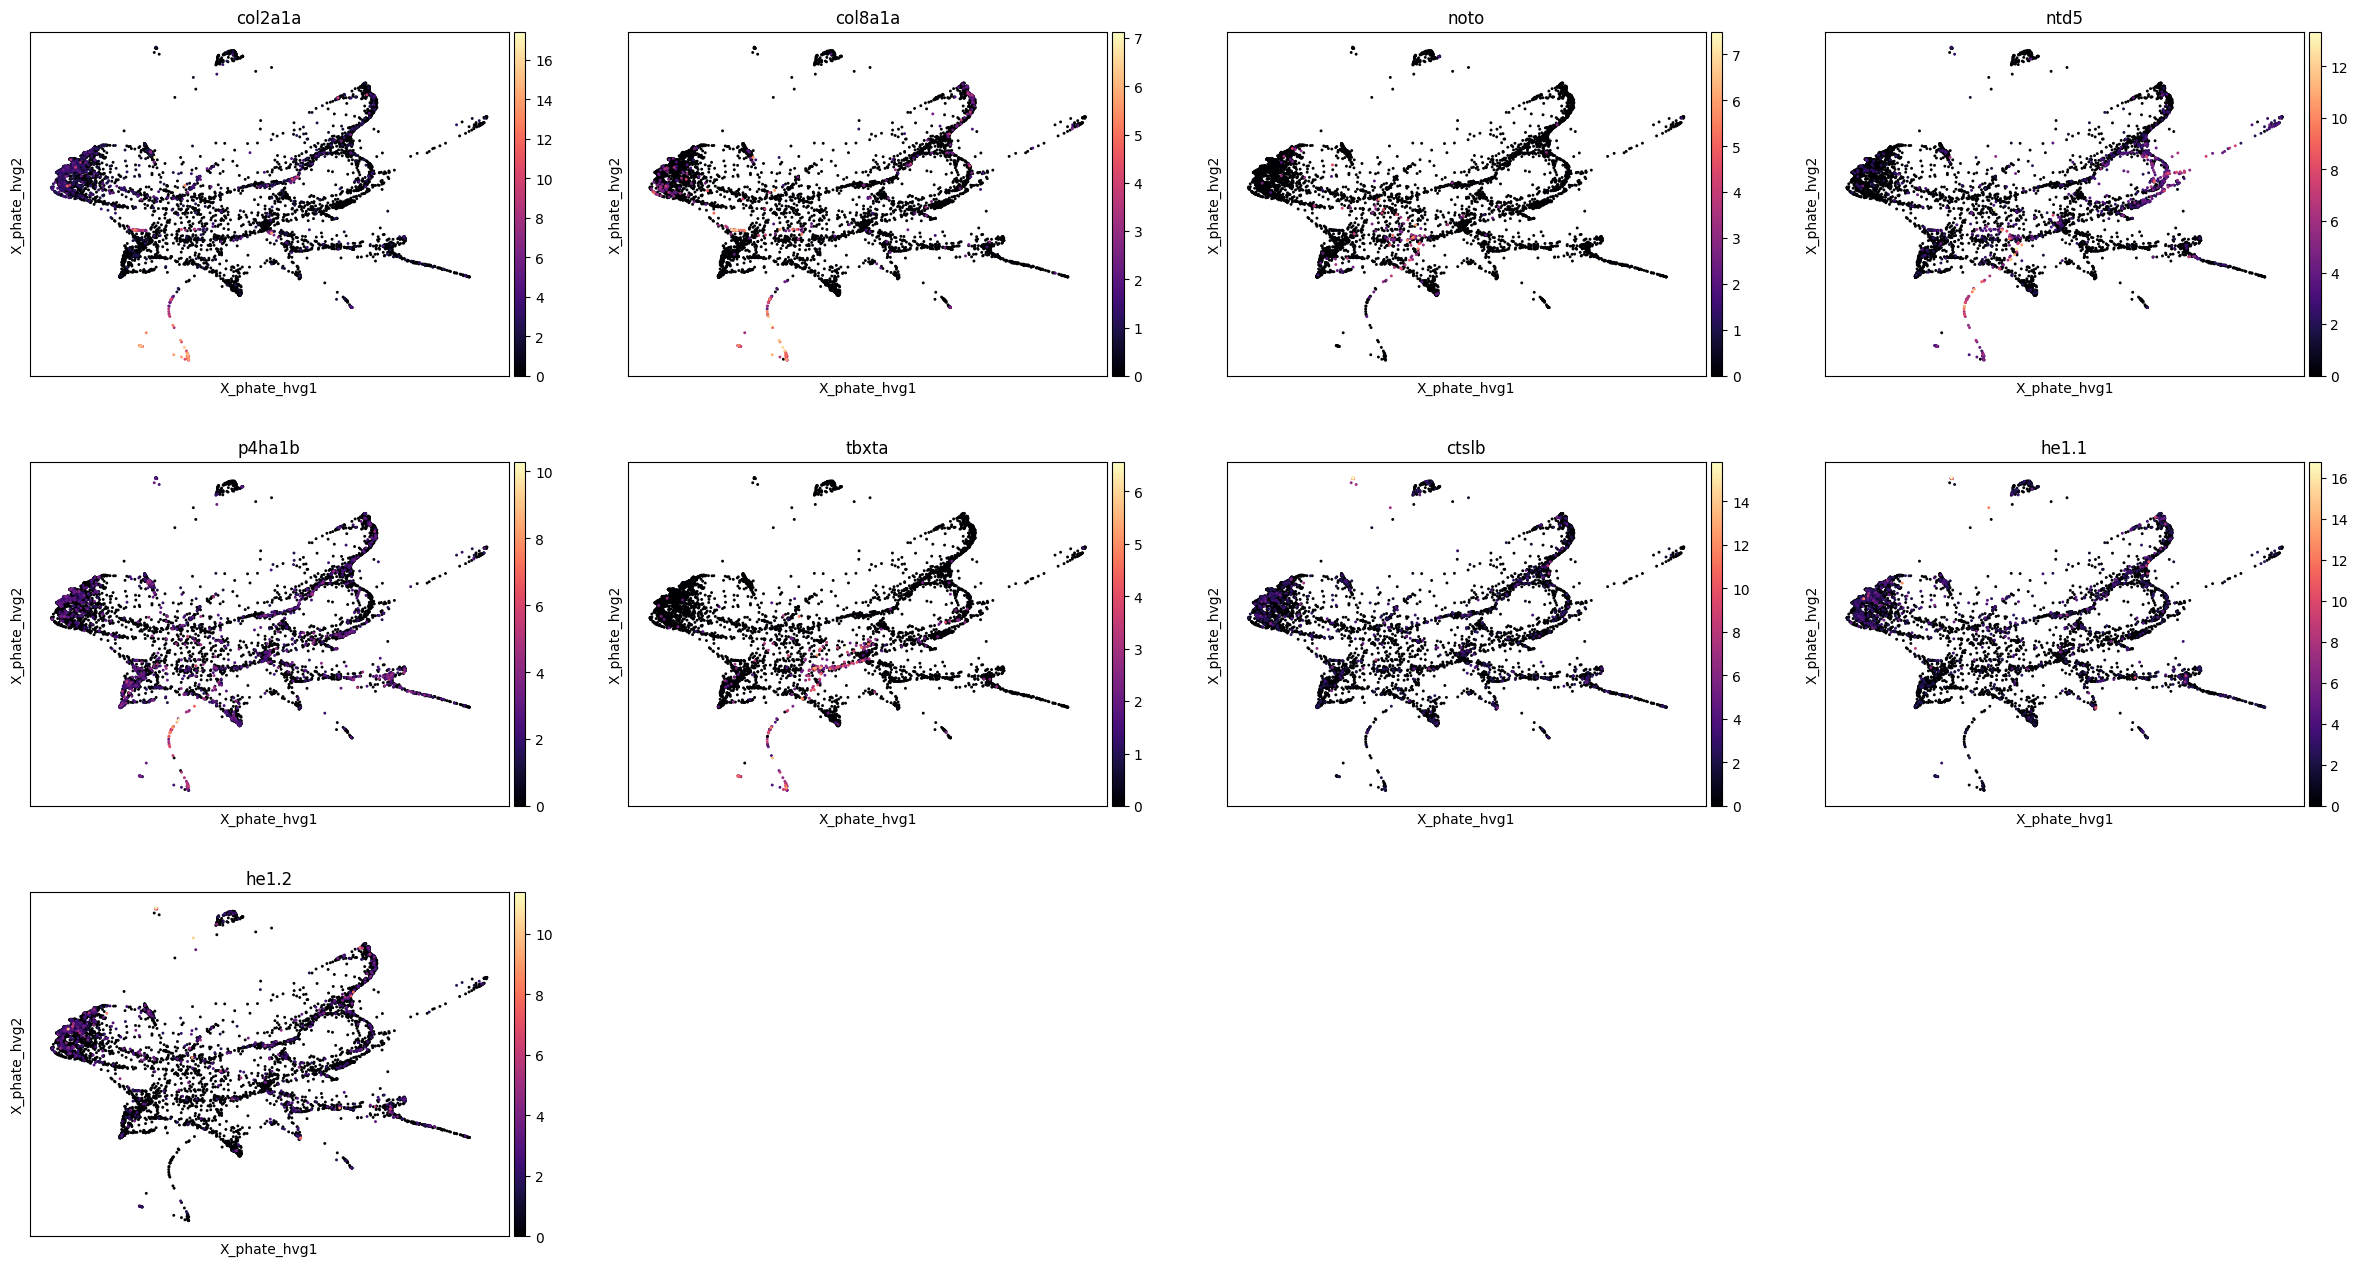

Axial-Mesoderm smoothed counts


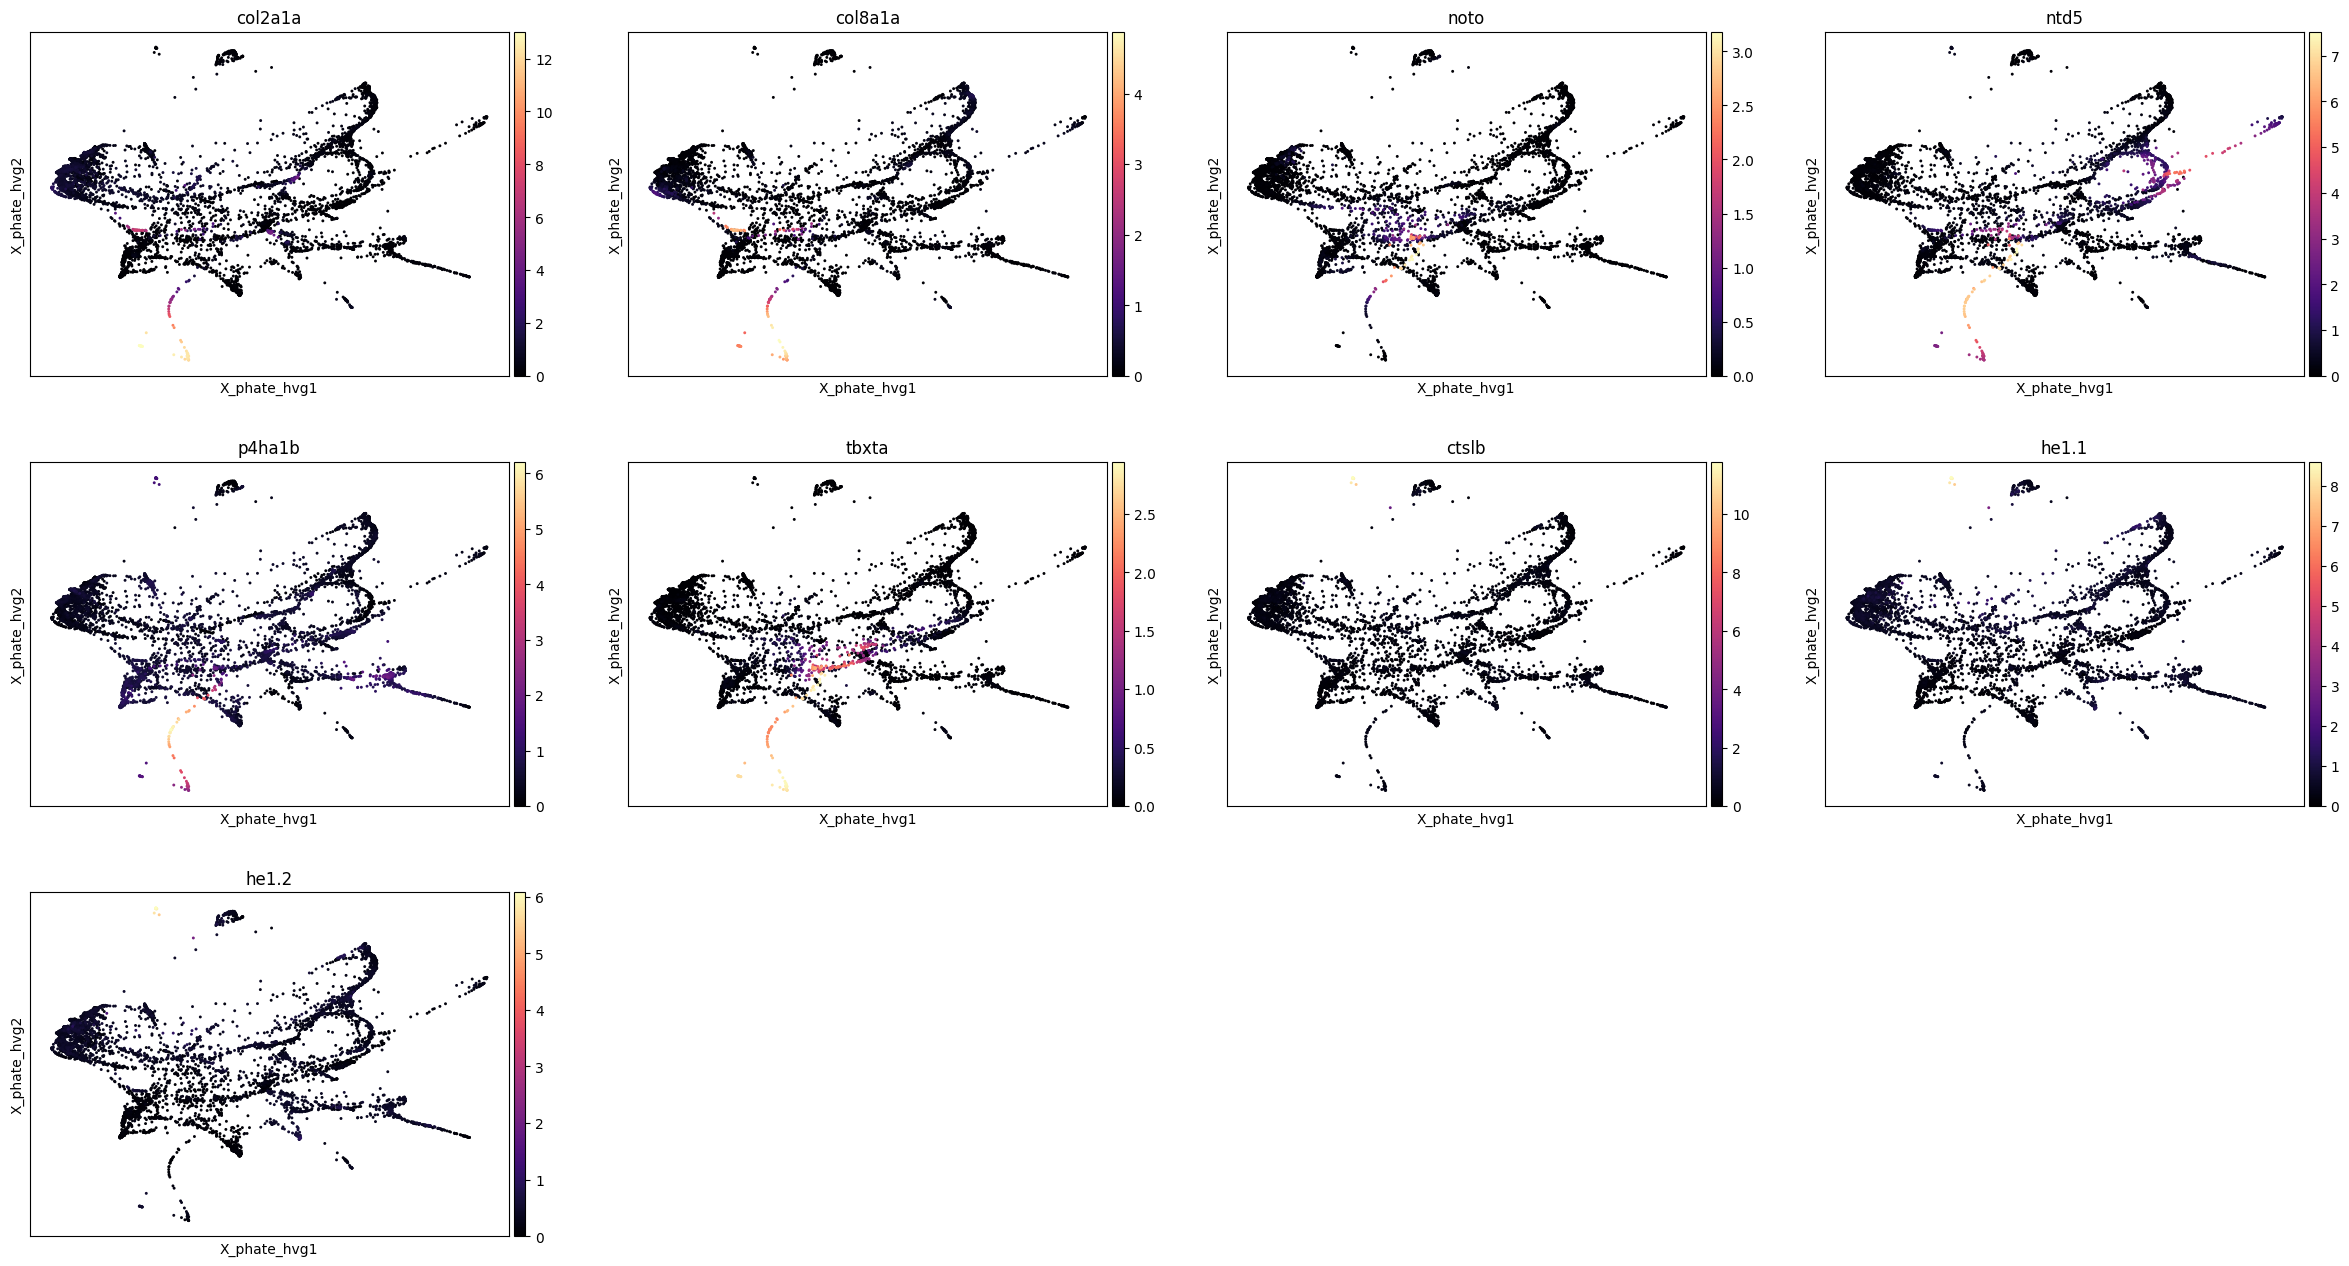

In [46]:
# Visualise marker embedding for each tissue
for tissue in marker_annotation.tissue.unique():
    tissue_annotation = marker_annotation[marker_annotation.tissue == tissue]
    GOIs = tissue_annotation.GeneSymbol
    GOI_list = [x for x in GOIs if x in adata.var_names]
    print(f'{tissue} normalised counts')
    sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=GOI_list, use_raw = True, color_map='magma')
    print(f'{tissue} smoothed counts')
    sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=GOI_list, use_raw = False, layer='X_magic', color_map='magma')
    break


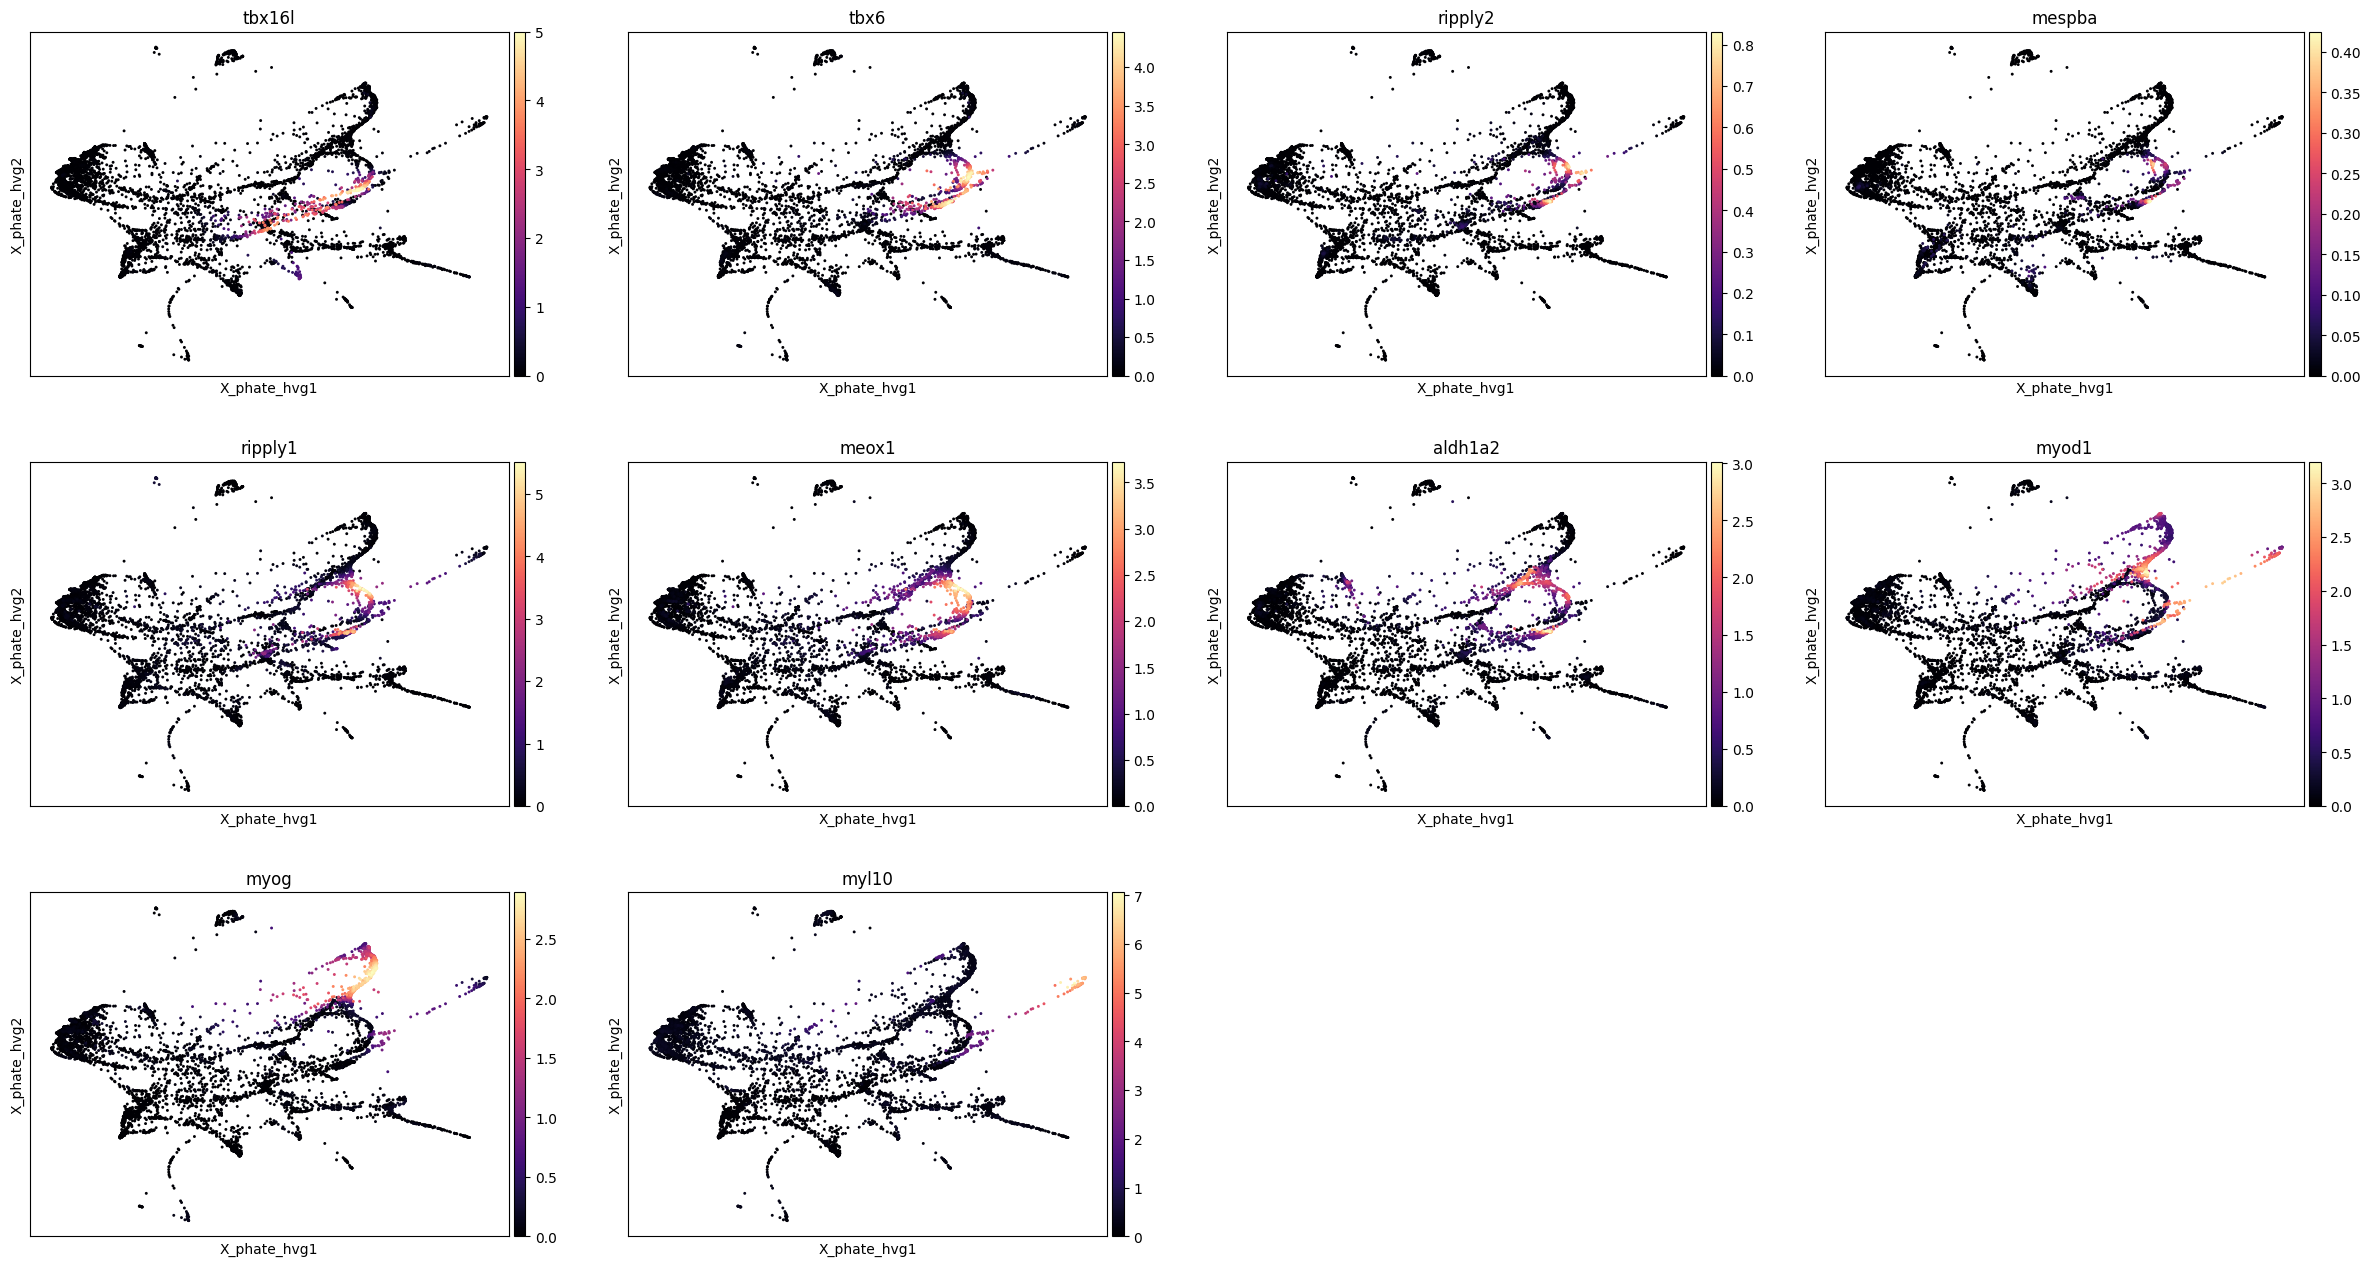

In [47]:
select_markers = ["tbx16l",  "tbx6", "ripply2", "mespba", "ripply1", "meox1", "aldh1a2", "myod1", "myog", "myl10"]
select_markers = [x for x in select_markers if x in adata.var_names]
sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=select_markers, use_raw = False, layer='X_magic', color_map='magma')

In [48]:
from degex.adata import (
    zscore_markers_in_layer, 
    subset_markers
)

In [49]:
adata = zscore_markers_in_layer(
    adata, 
    markers=select_markers,
    obs_key='PM_score'
)

<Axes: ylabel='Number of cells'>

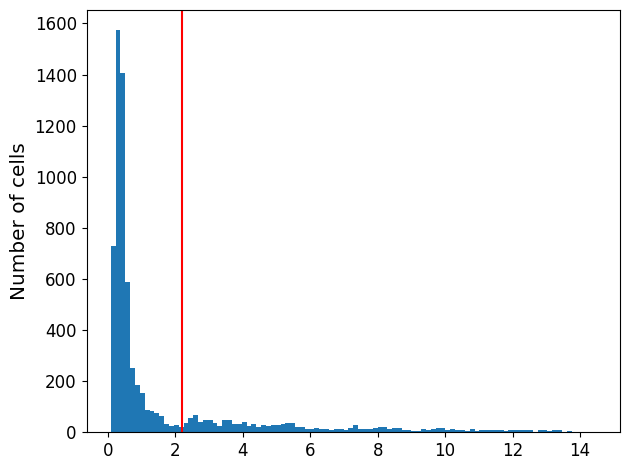

In [50]:
# Histogram of PM scores to find min threshold across all cells
min_score = 2.2
scprep.plot.histogram(adata.obs['PM_score'], cutoff=min_score)


In [53]:
adata = subset_markers(
    adata,
    obs_key='PM_cells',
    score_key='PM_score',
    marker_name='paraxial_mesoderm',    
)

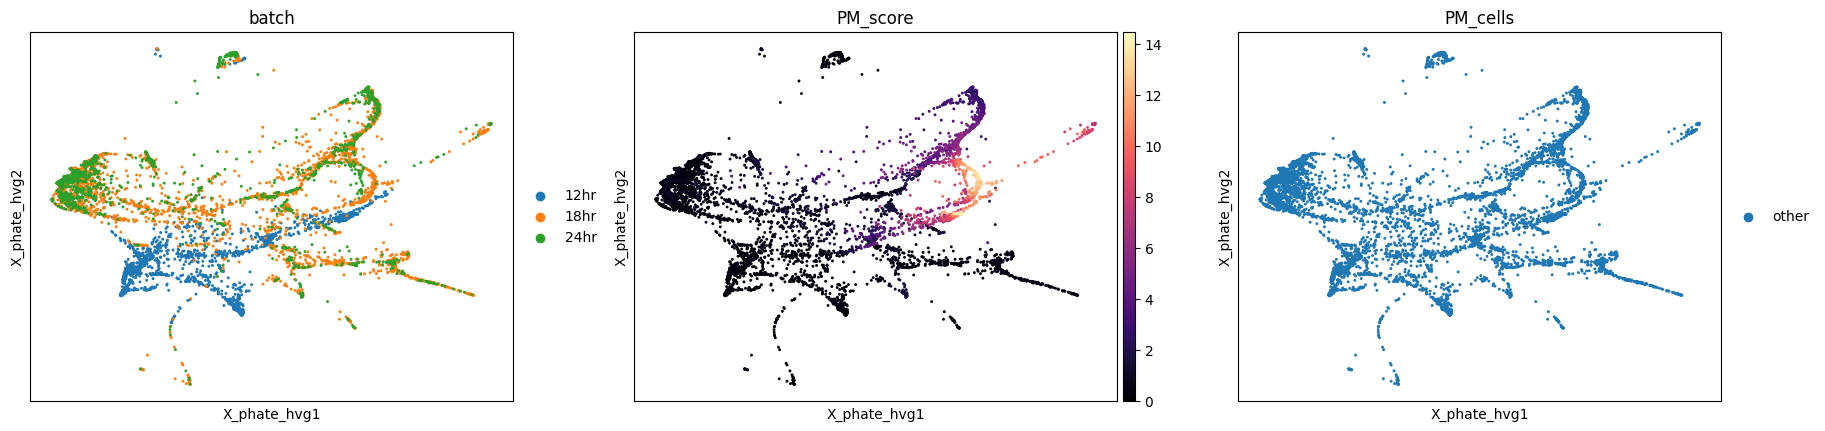

In [54]:
sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=['batch', 'PM_score', 'PM_cells'], use_raw = False, layer='X_magic', color_map='magma')